### Load data and choose rois

In [4]:
path = '/Users/jiamingxu/Desktop/Language_straightening/data/language/AA_wheretheressmoke.hf5'
with h5py.File(path, 'r') as file:
    file_name = list(file.keys())[0]
    response_trials = np.array(file[file_name])
    # get rid of the first 50 TRs (due to onset effect in AC)
    response_trials = response_trials[:, 50:, :]
    print(response_trials.shape) 

subject, xfm = 'AA', '20180905AA-sg-auto'
mask = cortex.db.get_mask(subject, xfm)

(10, 241, 95556)


In [2]:
%matplotlib inline
import cortex
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import h5py
import os
import nibabel as nib
from collections import defaultdict 
import statsmodels.api as sm

In [9]:
# choose functional roi 
f_rois = ['AC','sPMv']
f_roi_voxs = {} # get indices of roi voxels in cortical map
# get 3d mask of voxels that belong to roi
roi_masks = cortex.utils.get_roi_masks(subject, xfm, roi_list=f_rois, gm_sampler='cortical', split_lr=False, threshold=None, return_dict=True)
for roi in f_rois:
    roi_mask = roi_masks[roi]
    f_roi_voxs[roi] = np.where(roi_mask[np.where(mask)])[0]

# choose anatomical roi (PFC & precuneus)
%cd ..
%cd 'data/rois'
a_roi = ['parsopercularis','parstriangularis','superiorfrontal','rostralmiddlefrontal','caudalmiddlefrontal','frontalpole','precuneus']
roi_data = np.load(f'{subject}_roi.npy', allow_pickle=True).item()
a_roi_voxs = {}
for roi in a_roi:
    a_roi_voxs[roi] = roi_data[roi]
    
# combine PFC rois
rois_to_combine = [
    'parsopercularis',
    'parstriangularis',
    'superiorfrontal',
    'rostralmiddlefrontal',
    'caudalmiddlefrontal',
    'frontalpole'
]
pfc_voxs = []
for roi in rois_to_combine:
    pfc_voxs.extend(a_roi_voxs[roi])
    
pfc_voxs = list(set(pfc_voxs)) # remove potential duplicates

a_roi_voxs['prefrontal'] = pfc_voxs # update dict 

for roi in rois_to_combine: # remove old keys
    del a_roi_voxs[roi]


# combine functional and anatomical
roi_voxs = {**f_roi_voxs, **a_roi_voxs}  

# print number of voxels in each ROI
len(roi_voxs)
for key, value in roi_voxs.items():
    print(f"{key}: {len(value)} items")

Cutting 0 overlapping voxels (should be < ~50)
/Users/jiamingxu/Desktop/Language_straightening
/Users/jiamingxu/Desktop/Language_straightening/data/rois
AC: 2124 items
sPMv: 271 items
precuneus: 2845 items
prefrontal: 15222 items


### Fit AR(1) to individual runs (not using)

In [40]:
keys = roi_voxs.keys()
run_roi_ar1_coeffs = {key: np.zeros(10) for key in keys}
for roi in roi_voxs:
    for i in range(response_trials.shape[0]):
        roi_run = np.mean(response_trials[[i],:,roi_voxs[roi]].T, axis=1)
        roi_run_demean = zs(roi_run)
        run_roi_ar1_coeffs[roi][i] = build_arp_model(roi_run_demean, roi_run_demean, p=1)

avg_run_ar1_coeff = {key: np.mean(run_roi_ar1_coeffs[key]) for key in keys}
print(avg_run_ar1_coeff)

/var/folders/gq/_9ggz_gd2y57qgdgg8jsdz0r0000gp/T/ipykernel_98391/515564526.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  run_roi_ar1_coeffs[roi][i] = build_arp_model(roi_run_demean, roi_run_demean, p=1)


{'AC': 0.6722702441036583, 'sPMv': 0.6969508576333044, 'precuneus': 0.7640675912119453, 'prefrontal': 0.7472039721095121}


Inspect the distributions:

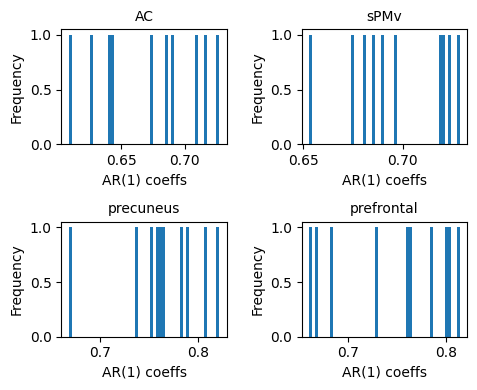

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(5, 4))
axes = axes.flatten()

for i, (roi, coeffs) in enumerate(run_roi_ar1_coeffs.items()):
    axes[i].hist(coeffs, bins=50)
    axes[i].set_title(f'{roi}', fontsize=10)  
    axes[i].set_xlabel("AR(1) coeffs", fontsize=10)  # Set font size for x-axis label
    axes[i].set_ylabel("Frequency", fontsize=10)  # Set font size for y-axis label

plt.tight_layout()
plt.show()

#### Significance testing

Sample entire runs with replacement 1000 times for each ROI, fit to AR(1) to get the null distribution of AR(1) coefficients. Then get error bars to see if differences between ROIs are significant. 

In [43]:
zs = lambda v: (v-v.mean(0))/v.std(0)
nboots = 1000
keys = roi_voxs.keys()
null_dist_run = {key: np.zeros(nboots) for key in keys}
for roi in roi_voxs:
    sample_runs = np.random.choice(response_trials.shape[0], size = nboots, replace=True)
    for i in range(nboots):
        roi_resp = response_trials[sample_runs[i],:,roi_voxs[roi]].T
        roi_mean = np.mean(response_trials[sample_runs[i],:,roi_voxs[roi]],axis = 0)
        roi_mean_norm = zs(roi_mean)
        ar1_model = sm.tsa.AutoReg(roi_mean_norm, lags = 1).fit()
        null_dist_run[roi][i] = ar1_model.params[1]

95% CI: [(0.6085418539962741, 0.7272065354823156), (0.6531700679122487, 0.7285818331518268), (0.6678248443734349, 0.8215872890158115), (0.6609461071779311, 0.8141401021593305)]
AR(1) Coefficient Estimates: [0.6722702441036583, 0.6969508576333044, 0.7640675912119453, 0.7472039721095121]


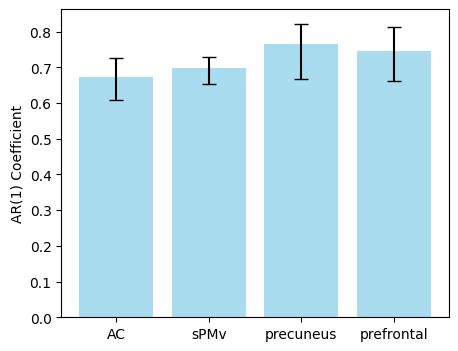

In [54]:
ci = []
for roi, dist in null_dist_run.items():
    lb = np.percentile(dist, 2.5)
    ub = np.percentile(dist, 97.5)
    ci.append((lb, ub))
print("95% CI:", ci)

ar1_coeff_est_run = []
for roi in avg_run_ar1_coeff:
    ar1_coeff_est_run.append((avg_run_ar1_coeff[roi]))
print("AR(1) Coefficient Estimates:", ar1_coeff_est_run)

lower_err = [ar1_coeff_est_run - ci[0] for ar1_coeff_est_run, ci in zip(ar1_coeff_est_run, ci)]
upper_err = [ci[1] - ar1_coeff_est_run for ar1_coeff_est_run, ci in zip(ar1_coeff_est_run, ci)]
err_bar = [lower_err, upper_err]

rois = roi_voxs.keys()
x = np.arange(len(rois))
plt.figure(figsize = (5,4))
plt.bar(x, ar1_coeff_est_run, yerr=err_bar, capsize=5, color='skyblue', alpha=0.7)

plt.xticks(x, rois)
plt.ylabel('AR(1) Coefficient')

plt.show()

### Fit AR(1) and AR(2) directly to average of 10 repeats

By doing this, we are fitting signal AND noise. We only want to fit signal. Need noise correction.

#### Significance testing (voxel-by-voxel) -- not working

Fit AR(1) to each voxel and get variability across voxels for each ROI, compute error bars. 

In [15]:
zs = lambda v: (v-v.mean(0))/v.std(0)
avg_reps = np.mean(response_trials,0)

roi_ar1_coeff = {}
roi_ar1_coeff_corrected = {}
roi_ar1_mean_se = {}

for roi in roi_voxs:
    n_voxs = len(roi_voxs[roi])
    print(n_voxs)
    roi_coeffs = np.zeros(n_voxs)
    corrected_roi_coeffs = np.zeros(n_voxs)

    for i in range(len(roi_voxs[roi])):
        demean_vox_resp = zs(avg_reps[:,roi_voxs[roi][i]])
        ar1_model = sm.tsa.AutoReg(demean_vox_resp, lags=1).fit()
        roi_coeffs[i] = ar1_model.params[1]

        # correct for bias
        scale = correct_bias_scale(response_trials[:,:,roi_voxs[roi][i]], len(response_trials[0]), len(response_trials[1]))
        corrected_roi_coeffs[i] = roi_coeffs[i] * scale

    roi_ar1_coeff[roi] = corrected_roi_coeffs


    # compute mean and SE
    mean_coeff = np.mean(corrected_roi_coeffs)
    se_coeff = np.std(corrected_roi_coeffs)/np.sqrt(n_voxs)

    roi_ar1_mean_se[roi] = {
        'mean': mean_coeff,
        'se': se_coeff,
    }

for roi, stats in roi_ar1_mean_se.items():
    print(f"ROI: {roi}, Mean Coefficient: {stats['mean']:.4f}, SE: {stats['se']:.4f}")

ROI: AC, Mean Coefficient: 0.4245, SE: 0.0044
ROI: sPMv, Mean Coefficient: 0.4615, SE: 0.0122
ROI: precuneus, Mean Coefficient: 0.4374, SE: 0.0044
ROI: prefrontal, Mean Coefficient: 0.4655, SE: 0.0018


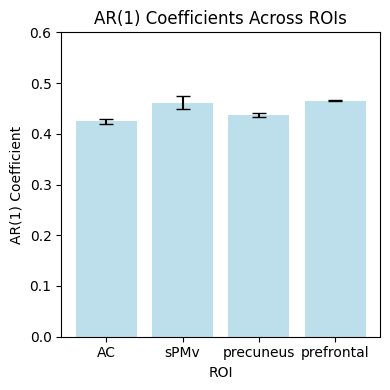

In [34]:
rois = list(roi_ar1_mean_se.keys())
means = [roi_ar1_mean_se[roi]['mean'] for roi in rois]
errors = [roi_ar1_mean_se[roi]['se'] for roi in rois]

# Plot
plt.figure(figsize=(4, 4))
plt.bar(rois, means, yerr=errors, capsize=5, color='lightblue', alpha=0.8)
plt.ylabel("AR(1) Coefficient")
plt.xlabel("ROI")
plt.ylim(0, 0.6)  # Adjust as needed
plt.title("AR(1) Coefficients Across ROIs")


# Display the plot
plt.tight_layout()
plt.show()

#### Significance testing (voxel average, 95% CI)

In [5]:
zs = lambda v: (v-v.mean(0))/v.std(0)
avg_reps = np.mean(response_trials,0)

roi_ar1_models = {}
roi_ar1_coeff = {}
roi_ar1_coeff_corrected = {}

for roi in roi_voxs:
    roi_demean_resp = zs(np.mean(avg_reps[:,roi_voxs[roi]], axis=1)) # run average x voxel average
    ar1_model = sm.tsa.AutoReg(roi_demean_resp, lags = 1).fit()
    roi_ar1_models[roi] = ar1_model
    roi_ar1_coeff[roi] = ar1_model.params[1]

    # correct for bias
    avg_voxs = np.mean(response_trials[:,:,roi_voxs[roi]], axis=2) # 10 runs x voxel average
    scale = correct_bias_scale(avg_voxs, len(response_trials[0]), len(response_trials[1]))
    roi_ar1_coeff_corrected[roi] = roi_ar1_coeff[roi] * scale

print(roi_ar1_coeff)
print(roi_ar1_coeff_corrected)


KeyboardInterrupt: 

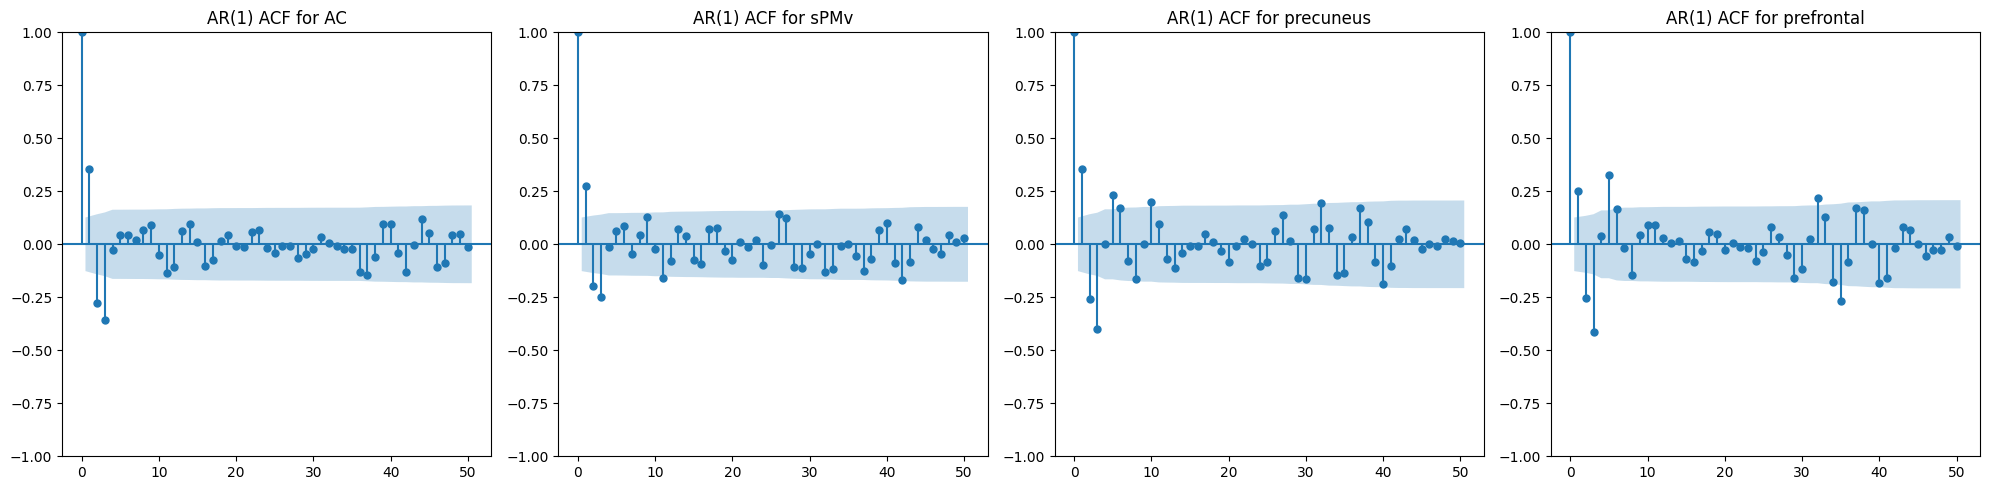

In [36]:
# sanity check
from statsmodels.graphics.tsaplots import plot_acf

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for idx, roi in enumerate(roi_ar1_models):
    # AR(1) residuals ACF
    residuals_ar1 = roi_ar1_models[roi].resid
    plot_acf(residuals_ar1, lags=50, ax=axes[idx])
    axes[idx].set_title(f'AR(1) ACF for {roi}')
plt.tight_layout()
# shaded area - 95% CI for autocorr = 0

##### Bootstrap: 
Sample 10 runs with replacement, find run average and fit to AR(1) model for each ROI. Repeat this process 100 times to get the null distribution of AR(1) coefficients. Then get error bars to see if differences between ROIs are significant. 

In [10]:
%time
from scipy.stats import bootstrap, norm
nruns = 10
nboots = 500
keys = roi_voxs.keys()
null_dist = {key: np.zeros(nboots) for key in keys}
null_dist_corrected = {key: np.zeros(nboots) for key in keys}
bca_ci = {}
for roi in roi_voxs:
    for i in range(nboots):
        sample_runs = np.random.choice(response_trials.shape[0], size = nruns, replace=True)
        sample_runs_resp = response_trials[sample_runs,:,:]
        roi_run_mean = np.mean(sample_runs_resp, axis=0)
        roi_vox_mean = zs(np.mean(roi_run_mean[:,roi_voxs[roi]], axis=1)) 
        ar1_model = sm.tsa.AutoReg(roi_vox_mean, lags = 1).fit()
        null_dist[roi][i] = ar1_model.params[1]

        # correct for bias
        avg_voxs = np.mean(sample_runs_resp[:,:,roi_voxs[roi]], axis=2) # 10 runs x voxel average
        scale = correct_bias_scale(avg_voxs, len(response_trials[0]), len(response_trials[1]))
        null_dist_corrected[roi][i] = null_dist[roi][i] * scale

# Compute Bias-Corrected and Accelerated (BCa) 95% CI
    data = null_dist_corrected[roi]
    observed_mean = np.mean(data)
    # 1) compute bias correction (z0)
    prop_below = np.mean(data < observed_mean)
    z0 = norm.ppf(prop_below)
    
    # 2) compute acceleration (a) using Jackknife
    jackknife_samples = np.zeros(nruns)
    for j in range(nruns):
        # Exclude one sample and calculate the statistic
        jackknife_data = np.delete(sample_runs_resp[:, :, roi_voxs[roi]], j, axis=0) # delete j-th run along axis 0
        jackknife_mean = np.mean(jackknife_data, axis=(0, 2))  # Average across runs and voxels
        jackknife_mean_norm = zs(jackknife_mean)
        ar1_model = sm.tsa.AutoReg(jackknife_mean_norm, lags=1).fit()
        jackknife_samples[j] = ar1_model.params[1]

    theta_bar = np.mean(jackknife_samples)  # Mean of jackknife estimates
    numerator = np.sum((theta_bar - jackknife_samples) ** 3)
    denominator = np.sum((theta_bar - jackknife_samples) ** 2) ** 1.5
    a = numerator / (6 * denominator)  # Acceleration term

    # 3) Adjust Percentiles
    alpha = 0.05  # For 95% CI
    z_low = norm.ppf(alpha / 2)  # Lower critical value
    z_high = norm.ppf(1 - alpha / 2)  # Upper critical value

    # Corrected percentiles
    adjusted_alpha_low = norm.cdf(z0 + (z0 + z_low) / (1 - a * (z0 + z_low)))
    adjusted_alpha_high = norm.cdf(z0 + (z0 + z_high) / (1 - a * (z0 + z_high)))

    # 4) Compute Confidence Interval
    ci_low = np.percentile(data, adjusted_alpha_low * 100)
    ci_high = np.percentile(data, adjusted_alpha_high * 100)
    bca_ci[roi] = (ci_low, ci_high) 

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 7.87 µs


In [4]:
# Plotting with BCa corrected 95% CI
means = [float(roi_ar1_coeff_corrected[roi]) for roi in rois]
errors = [
    (float(means[idx]) - float(bca_ci[roi][0]), float(bca_ci[roi][1]) - float(means[idx]))
    for idx, roi in enumerate(rois)
]
lower_err, upper_err = zip(*errors)  # Separate lower and upper error bars

# Create bar plot
plt.figure(figsize=(5,4))
plt.bar(rois, means, yerr=[lower_err, upper_err], capsize=5, color='skyblue', alpha=0.8)
plt.ylabel("AR(1) Coefficient")
plt.xlabel("ROI")
plt.title("AR(1) Coefficients with BCa 95% CI")
plt.ylim(0, 1)  # Adjust based on your data range
plt.tight_layout()
plt.savefig("ar1_coefficients_95ci_corrected.pdf", format="pdf")
plt.show()


NameError: name 'rois' is not defined

95% CI: [(0.6489206934660928, 0.7382151576789274), (0.6866520930430062, 0.7758041532582536), (0.7766158704867333, 0.8689958071390881), (0.7597620431023925, 0.8888705065800199)]
AR(1) Coefficient Estimates: [0.7074795217789887, 0.7481918065749903, 0.8530303293976325, 0.8746460687865146]


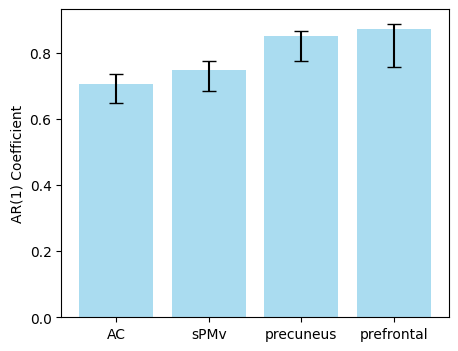

In [43]:
# Compute 95% CI without correction
ci = []
for roi, dist in null_dist_corrected.items():
    lb = np.percentile(dist, 2.5)
    ub = np.percentile(dist, 97.5)
    ci.append((lb, ub))
print("95% CI:", ci)

ar1_coeff_est = []
for roi in roi_ar1_coeff_corrected:
    ar1_coeff_est.append(roi_ar1_coeff_corrected[roi])
print("AR(1) Coefficient Estimates:", ar1_coeff_est)

lower_err = [ar1_coeff_est - ci[0] for ar1_coeff_est, ci in zip(ar1_coeff_est, ci)]
upper_err = [ci[1] - ar1_coeff_est for ar1_coeff_est, ci in zip(ar1_coeff_est, ci)]
err_bar = [lower_err, upper_err]

rois = roi_voxs.keys()
x = np.arange(len(rois))
plt.figure(figsize = (5,4))
plt.bar(x, ar1_coeff_est, yerr=err_bar, capsize=5, color='skyblue', alpha=0.7)

plt.xticks(x, rois)
plt.ylabel('AR(1) Coefficient')

plt.show()

Error bars are asymmetric, why?

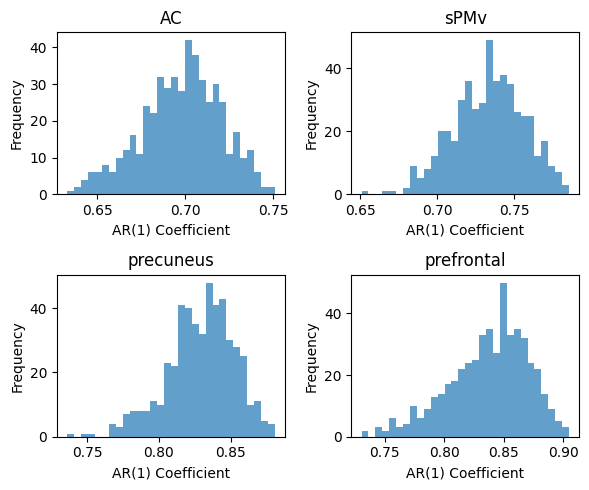

In [44]:
fig, axes = plt.subplots(2, 2, figsize=(6, 5)) 
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration
for idx, (roi, dist) in enumerate(null_dist.items()):
    ax = axes[idx]
    ax.hist(dist, bins=30, alpha=0.7)
    ax.set_title(f'{roi}')
    ax.set_xlabel('AR(1) Coefficient')
    ax.set_ylabel('Frequency')

for i in range(len(null_dist), len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

##### Compute P-values (pairwise comparisons)
Get the percentile of mean estimates within the distributions of other ROIs.

In [40]:
from scipy.stats import percentileofscore
percentiles = []
for i, roi1 in enumerate(rois):
    for j, roi2 in enumerate(rois):
        if i != j:
            percentile = percentileofscore(null_dist_corrected[roi1], roi_ar1_coeff_corrected[roi2], kind='rank')
            percentiles.append((roi1, roi2, percentile))
            print(f"percentile of {roi2} in {roi1}'s distribution: {percentile}%")

percentile of sPMv in AC's distribution: 99.60000000000001%
percentile of precuneus in AC's distribution: 100.0%
percentile of prefrontal in AC's distribution: 100.0%
percentile of AC in sPMv's distribution: 14.0%
percentile of precuneus in sPMv's distribution: 100.0%
percentile of prefrontal in sPMv's distribution: 100.0%
percentile of AC in precuneus's distribution: 0.0%
percentile of sPMv in precuneus's distribution: 0.2%
percentile of prefrontal in precuneus's distribution: 98.80000000000001%
percentile of AC in prefrontal's distribution: 0.0%
percentile of sPMv in prefrontal's distribution: 1.0%
percentile of precuneus in prefrontal's distribution: 65.0%


### Cross-fit AR models

Z = average of 5 runs, X = average of the other 5 runs
$$ Z_t = \alpha \cdot X_{t-1} $$

In [10]:
zs = lambda v: (v-v.mean(0))/v.std(0)

def make_delayed(stim, delays, circpad=False):
    """Creates non-interpolated concatenated delayed versions of [stim] with the given [delays] 
    (in samples).
    
    If [circpad], instead of being padded with zeros, [stim] will be circularly shifted.
    """
    nt,ndim = stim.shape
    dstims = []
    for di,d in enumerate(delays):
        dstim = np.zeros((nt, ndim))
        if d<0: ## negative delay
            dstim[:d,:] = stim[-d:,:]
            if circpad:
                dstim[d:,:] = stim[:-d,:]
        elif d>0:
            dstim[d:,:] = stim[:-d,:]
            if circpad:
                dstim[:d,:] = stim[-d:,:]
        else: ## d==0
            dstim = stim.copy()
        dstims.append(dstim)
    return np.hstack(dstims)

def make_arp_x(sig, p):
    """Returns linear AR(p) model predictors for the given signal, [sig].
    """
    if sig.ndim == 1:
        sig = sig.reshape(-1, 1)
    return make_delayed(sig, range(1, p+1)).T


def build_arp_model(resp1, resp2, p=1):
    """Builds an autoregressive model for [resp] with [p] previous timepoints.
    [resp] should be a 1D vector
    [p] should be an integer in [1..]
    """
    dr = make_arp_x(resp1, p)
    wt, rank, res, sing = np.linalg.lstsq(dr.T, resp2, rcond=None)
    return wt

In [44]:
import random
runs = list(range(10))
nloops = 50
keys = roi_voxs.keys()
coeffs = {key: np.zeros(nloops) for key in keys}
for i in range(nloops):
    for roi in roi_voxs:
        runs1 = random.sample(runs, 5)
        avg_runs1 = np.mean(np.mean(response_trials[runs1,:,:][:,:,roi_voxs[roi]], axis=0), axis=-1)
        runs2 = list(set(runs) - set(runs1))
        avg_runs2 = np.mean(np.mean(response_trials[runs2,:,:][:,:,roi_voxs[roi]],axis=0), axis=-1)
        # cross fit AR(1)
        zresp1 = zs(avg_runs1)
        zresp2 = zs(avg_runs2)
        coeffs[roi][i] = build_arp_model(zresp1, zresp2, p=1)

avg_coeff = {key: np.mean(coeffs[key]) for key in keys}
print(avg_coeff)

/var/folders/gq/_9ggz_gd2y57qgdgg8jsdz0r0000gp/T/ipykernel_60745/1071951479.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  coeffs[roi][i] = build_arp_model(avg_runs1, avg_runs2, p=1)


{'AC': 0.5134997017002031, 'sPMv': 0.42785860576214796, 'precuneus': 0.48839237520604, 'prefrontal': 0.4956631265192726}


### Simulate some fake data to test things out

In [41]:
# def add_shared_noise(nTimepoints, nSamples, decay_coeff=1):
#     """Generates noise with an exponential decay covariance structure."""
#     covmat = scipy.linalg.toeplitz(np.exp(-np.linspace(0,1,nTimepoints)**2/decay_coeff**2))
#     print(covmat)
#     return np.random.multivariate_normal(np.zeros(nTimepoints),covmat,nSamples).T

def make_arp(ar_coeff, nT):
    p = len(ar_coeff)
    noise = np.random.randn(nT) # noise at each timepoint
    signal = np.zeros(nT)
    signal[:p] = noise[:p]
    w = ar_coeff[::-1]
    
    for t in range(p, nT):
        signal[t] = np.dot(w, signal[t-p:t]) + noise[t]
    return signal

def make_arp_vec(ar_coeff, nSeries, nT):
    """Generates nSeries independent AR(1) time series of length nT."""
    return np.vstack([make_arp(ar_coeff, nT) for _ in range(nSeries)]).T

def make_correlated_arp(ar_coeff, nT, n_series, corr=1, noise_std=1):
    shared_noise_std = noise_std * np.sqrt(corr) # signal
    unique_noise_std = noise_std * np.sqrt(1 - corr)
    
    time_series = np.zeros((n_series, nT))
    
    shared_noise = np.random.randn(nT) * shared_noise_std
    unique_noise = np.random.randn(n_series, nT) * unique_noise_std  # unique noise for each series
    
    for i in range(n_series):
        time_series[i, 0] = shared_noise[0] + unique_noise[i, 0]
    
    for t in range(1, nT):
        for i in range(n_series):
            time_series[i, t] = ar_coeff * time_series[i, t - 1] + shared_noise[t] + unique_noise[i, t]
    
    return time_series

#### Test on fitting run average

##### By ROI (simulate timeseries with different AR coefficients)

In [218]:
nT = 100 # number of timepoints
nRuns = 10
real_ar_coeff = np.array([0.2, 0.4, 0.6, 0.8])
keys = roi_voxs.keys() #['AC', 'sPMv', 'precuneus', 'prefrontal']
sim_data = {key: np.zeros((nRuns,nT)) for key in keys}

for i, roi in enumerate(sim_data):
    for run in range(nRuns):
        sim_data[roi][run,:] = make_arp_vec([real_ar_coeff[i]], 1, nT).flatten()

In [225]:
ar1_coeffs = {}
for roi in sim_data:
    avg_reps = np.mean(sim_data[roi],0)
    norm_avg_reps = zs(avg_reps)
    ar1_model = sm.tsa.AutoReg(norm_avg_reps, lags = 1).fit()
    ar1_coeffs[roi] = ar1_model.params[1]

print(f"{'ROI':<12} | {'Ground truth AR(1) Coeff':<10} | {'Recovered AR(1) Coeff':<10}")
print("-" * 60)  
for i,roi in enumerate(roi_ar1_models):
    ar1_model = roi_ar1_models[roi]
    ar1_coeff = ar1_model.params[1]
    ar1_real = real_ar_coeff[i]
    print(f"{roi:<12} |{ar1_real:<25f} | {ar1_coeff:<10.4f} ")

ROI          | Ground truth AR(1) Coeff | Recovered AR(1) Coeff
------------------------------------------------------------
AC           |0.100000                  | 0.0388     
sPMv         |0.300000                  | 0.1321     
precuneus    |0.500000                  | 0.4580     
prefrontal   |0.900000                  | 0.7305     


##### Correct for bias

There's a bias in the AR coeff estimator that's ~$(\hat{\alpha}*n_{t-1})^2$, where $n$ is the average of the individual noise of all the runs. Simulate this 1000 times to get the distribution of $\hat{\alpha}$ over $\alpha$ to inspect the bias. 
Generate correlated timeseries (added shared noise component in addition to individual noise).

Text(0, 0.5, 'Est. AR coeffs')

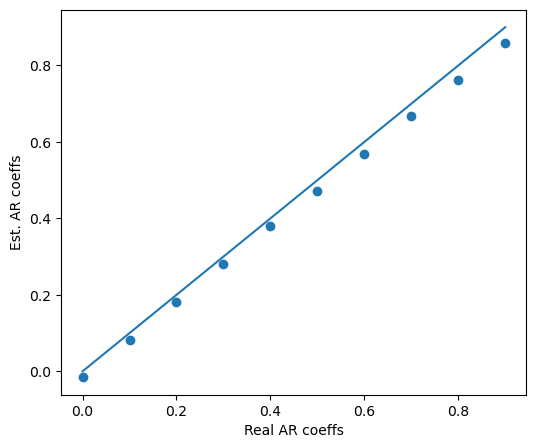

In [43]:
nLoops = 1000 
nT = 100 # number of timepoints
nRuns = 10
real_ar_coeff = np.arange(0,1,0.1)
sim_data = np.zeros((nLoops, len(real_ar_coeff), nRuns, nT))
est_ar_coeff = np.zeros((nLoops, len(real_ar_coeff)))

for loop in range(nLoops):
    for coeff in range(len(real_ar_coeff)):
        sim_data[loop, coeff, :, :] = make_correlated_arp(real_ar_coeff[coeff], nT, nRuns, corr=0.1)
        zs_avg_resp = zs(np.mean(sim_data[loop,coeff,:,:],axis=0))
        ar1_model = sm.tsa.AutoReg(zs_avg_resp, lags = 1).fit()
        est_ar_coeff[loop,coeff] = ar1_model.params[1]

avg_est_ar_coeff = np.mean(est_ar_coeff,0)

plt.figure(figsize=(6,5))
plt.scatter(real_ar_coeff, avg_est_ar_coeff)
plt.plot(real_ar_coeff, real_ar_coeff)
plt.xlabel("Real AR coeffs")
plt.ylabel("Est. AR coeffs")

##### Correct bias with additive method (not using)

In [69]:
def correct_bias_additive(response_trials, nRuns, nT):
    # response_trials should have the shape (nRuns, timepoints)
    avg_resp = np.mean(response_trials, axis=0)
    residuals = response_trials - avg_resp
    mean_residuals = np.mean(residuals, axis=0)
    residuals_var = np.sum((residuals - mean_residuals)**2, axis=0) / (nRuns - 1)
    avg_residual_var = np.mean(residuals_var, axis=0)
    
    sigma_n_sq = avg_residual_var/(nRuns - 1)  
    
    return sigma_n_sq

Text(0, 0.5, 'Est. AR coeffs')

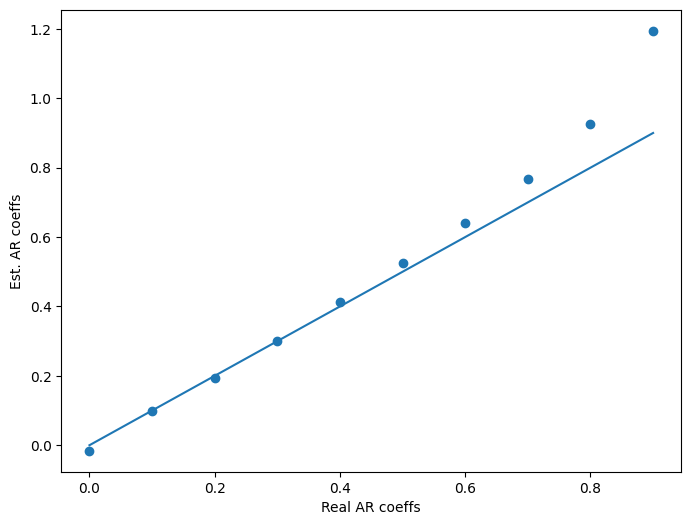

In [99]:
corrected_ar_coeff = np.zeros((nLoops, len(real_ar_coeff)))
for loop in range(nLoops):
    for coeff in range(len(real_ar_coeff)):
        sigma_n_sq = correct_bias_additive(sim_data[loop, coeff, :, :], nRuns, nT)
        corrected_ar_coeff[loop,coeff] = est_ar_coeff[loop, coeff] + (est_ar_coeff[loop, coeff] * sigma_n_sq)

avg_corrected_ar_coeff = np.mean(corrected_ar_coeff,0)

plt.figure(figsize=(8,6))
plt.scatter(real_ar_coeff, avg_corrected_ar_coeff)
plt.plot(real_ar_coeff, real_ar_coeff)
plt.xlabel("Real AR coeffs")
plt.ylabel("Est. AR coeffs")

##### Correct bias with scaling method:

In [14]:
def correct_bias_scale(response_trials, nRuns, nT):
    # response_trials should have the shape (nRuns, timepoints)
    avg_resp = zs(np.mean(response_trials, axis=0))
    residuals = response_trials - avg_resp
    resp_var = np.sum(residuals**2, axis=0) / (nRuns - 1)
    avg_resp_var = np.mean(resp_var, axis=0)
    
    mean_residuals = np.mean(residuals, axis=0)
    residuals_var = np.sum((residuals - mean_residuals)**2, axis=0) / (nRuns - 1)
    avg_residuals_var = np.mean(residuals_var, axis=0)
    
    sigma_n_sq = avg_residuals_var/(nRuns - 1)  
    #print(sigma_n_sq)

    # get variance of y_t
    sigma_y_sq = avg_resp_var - sigma_n_sq
    #print(sigma_y_sq)

    # get scaling factor 
    scale = np.sqrt(1 + (sigma_n_sq / sigma_y_sq))

    return scale

Text(0, 0.5, 'Est. AR coeffs')

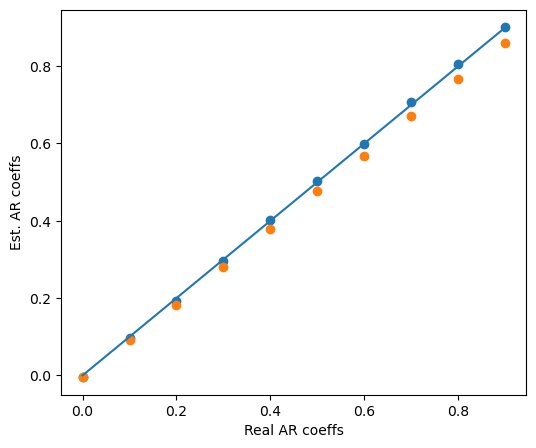

In [16]:
corrected_ar_coeff = np.zeros((nLoops, len(real_ar_coeff)))
for loop in range(nLoops):
    for coeff in range(len(real_ar_coeff)):
        scale = correct_bias_scale(sim_data[loop, coeff, :, :], nRuns, nT)
        corrected_ar_coeff[loop,coeff] = est_ar_coeff[loop, coeff] * scale

avg_corrected_ar_coeff = np.mean(corrected_ar_coeff,0)

plt.figure(figsize=(6,5))
plt.scatter(real_ar_coeff, avg_corrected_ar_coeff)
plt.scatter(real_ar_coeff, avg_est_ar_coeff)
plt.plot(real_ar_coeff, real_ar_coeff)
plt.xlabel("Real AR coeffs")
plt.ylabel("Est. AR coeffs")

#### Sanity check for scaling correction: test with different noise levels

Text(0, 0.5, 'Est vs real AR coeffs')

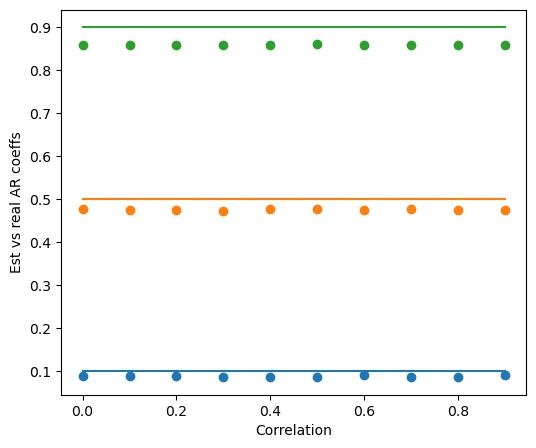

In [71]:
nLoops = 1000 
nT = 100 # number of timepoints
nRuns = 10
real_ar_coeff = np.array([0.1, 0.5, 0.9])
corrs = np.arange(0,1,0.1)
sim_data = np.zeros((nLoops, len(real_ar_coeff), len(corrs), nRuns, nT))
run_avg_est_ar_coeff = np.zeros((nLoops, len(real_ar_coeff), len(corrs)))

for loop in range(nLoops):
    for coeff in range(len(real_ar_coeff)):
        for corr in range(len(corrs)):
            sim_data[loop, coeff, corr, :, :] = make_correlated_arp(real_ar_coeff[coeff], nT, n_series=nRuns, corr=corrs[corr]) 
            est_ar_coeff = []
            for run in range(nRuns): 
                zs_resp = zs(sim_data[loop, coeff, corr, run,:])
                ar1_model = sm.tsa.AutoReg(zs_resp, lags = 1).fit()
                est_ar_coeff.append(ar1_model.params[1])  
            run_avg_est_ar_coeff[loop,coeff,corr] = np.mean(est_ar_coeff)

avg_est_ar_coeff = np.mean(run_avg_est_ar_coeff, axis=0)


plt.figure(figsize=(6,5))
for coeff in range(len(real_ar_coeff)):
    plt.scatter(corrs, avg_est_ar_coeff[coeff,:])
    plt.plot(corrs, [real_ar_coeff[coeff]] * len(corrs))
plt.xlabel("Correlation")
plt.ylabel("Est vs real AR coeffs")

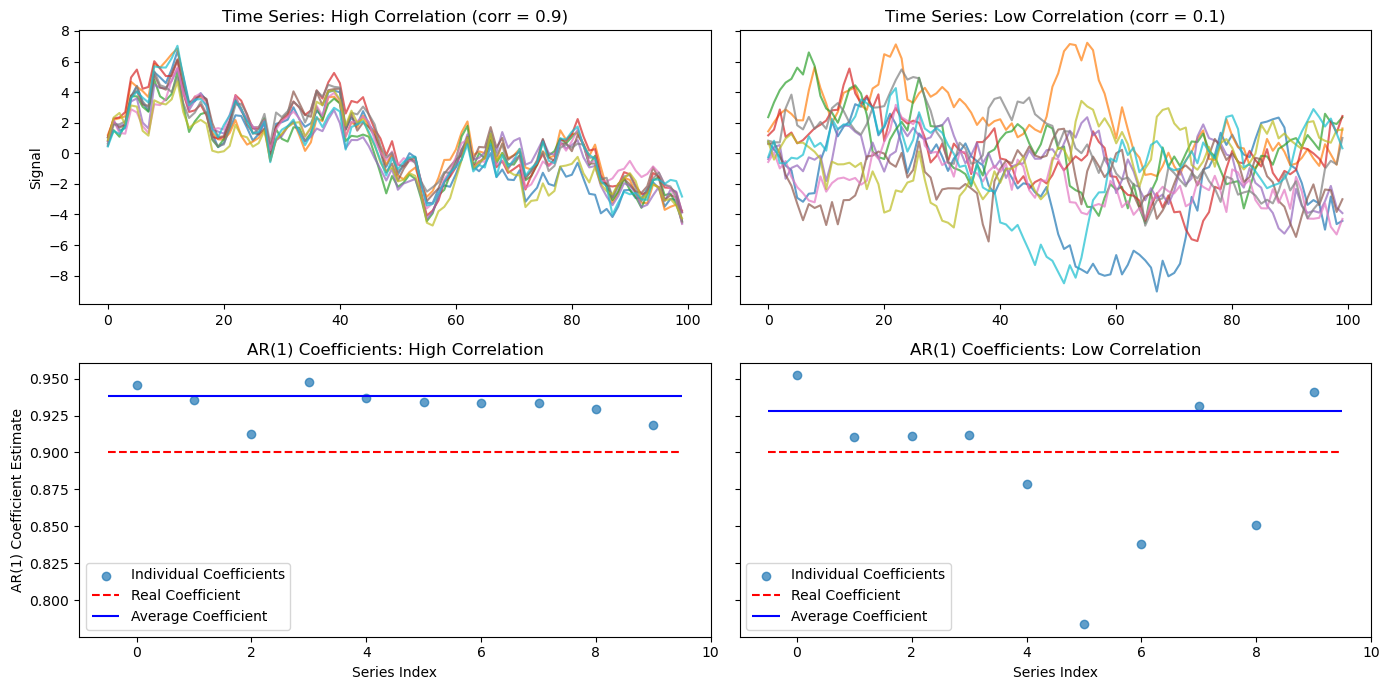

In [64]:
ar_coeff = 0.9
nT = 100
n_series = 10

# Generate time series
time_series_high_corr = make_correlated_arp(ar_coeff, nT, n_series, corr=0.9, noise_std=1)
time_series_low_corr = make_correlated_arp(ar_coeff, nT, n_series, corr=0.1, noise_std=1)

# Function to fit AR(1) and calculate coefficients
def fit_ar1(time_series):
    ind_coeffs = []
    for series in time_series:
        zs_series = zs(series)
        ar1_model = sm.tsa.AutoReg(zs_series, lags=1).fit()
        ind_coeffs.append(ar1_model.params[1])
    zs_avg_series = zs(np.mean(time_series, axis=0))
    ar1_avg_model = sm.tsa.AutoReg(zs_avg_series, lags=1).fit()
    avg_coeff = ar1_avg_model.params[1]
    return ind_coeffs, avg_coeff

# Fit AR(1) models
ind_coeffs_high_corr, avg_coeff_high_corr = fit_ar1(time_series_high_corr)
ind_coeffs_low_corr, avg_coeff_low_corr = fit_ar1(time_series_low_corr)

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(14, 7), gridspec_kw={'height_ratios': [1, 1]}, sharey='row')

# Top row: Time series
axes[0, 0].set_title('Time Series: High Correlation (corr = 0.9)')
for series in time_series_high_corr:
    axes[0, 0].plot(series, alpha=0.7)
axes[0, 0].set_ylabel('Signal')

axes[0, 1].set_title('Time Series: Low Correlation (corr = 0.1)')
for series in time_series_low_corr:
    axes[0, 1].plot(series, alpha=0.7)

# Bottom row: AR(1) coefficient estimates
axes[1, 0].scatter(range(len(ind_coeffs_high_corr)), ind_coeffs_high_corr, label='Individual Coefficients', alpha=0.7)
axes[1, 0].hlines(ar_coeff, xmin=-0.5, xmax=len(ind_coeffs_high_corr) - 0.5, colors='red', linestyles='--', label='Real Coefficient')
axes[1, 0].hlines(avg_coeff_high_corr, xmin=-0.5, xmax=len(ind_coeffs_high_corr) - 0.5, colors='blue', linestyles='-', label='Average Coefficient')
axes[1, 0].set_title('AR(1) Coefficients: High Correlation')
axes[1, 0].set_xlabel('Series Index')
axes[1, 0].set_ylabel('AR(1) Coefficient Estimate')
axes[1, 0].legend()

axes[1, 1].scatter(range(len(ind_coeffs_low_corr)), ind_coeffs_low_corr, label='Individual Coefficients', alpha=0.7)
axes[1, 1].hlines(ar_coeff, xmin=-0.5, xmax=len(ind_coeffs_low_corr) - 0.5, colors='red', linestyles='--', label='Real Coefficient')
axes[1, 1].hlines(avg_coeff_low_corr, xmin=-0.5, xmax=len(ind_coeffs_low_corr) - 0.5, colors='blue', linestyles='-', label='Average Coefficient')
axes[1, 1].set_title('AR(1) Coefficients: Low Correlation')
axes[1, 1].set_xlabel('Series Index')
axes[1, 1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

#### Test on cross fitting

In [185]:
import random
runs = list(range(10))
nloops = 50
keys = roi_voxs.keys()
coeffs = {key: np.zeros(nloops) for key in keys}
for i in range(nloops):
    for roi in sim_data:
        runs1 = random.sample(runs, 5)
        avg_runs1 = np.mean(sim_data[roi][runs1,:],axis=0)
        runs2 = list(set(runs) - set(runs1))
        avg_runs2 = np.mean(sim_data[roi][runs2,:],axis=0)
        # cross fit AR(1)
        zresp1 = zs(avg_runs1)
        zresp2 = zs(avg_runs2)
        coeffs[roi][i] = build_arp_model(zresp1, zresp2, p=1)

avg_coeff = {key: np.mean(coeffs[key]) for key in keys}
print(avg_coeff)

{'AC': 0.011224603075446345, 'sPMv': -0.08409246702178759, 'precuneus': -0.10890684484654582, 'prefrontal': -0.3118388250260495}


Cross-fitting doesn't seem to work... why?

corr = -0.1567482027881505


<function matplotlib.pyplot.show(close=None, block=None)>

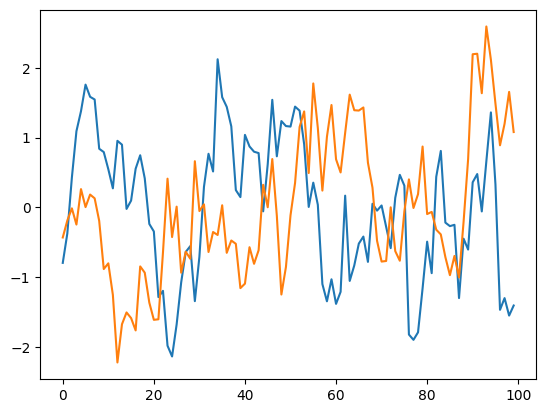

In [216]:
corr = np.corrcoef(zresp1, make_arp_x(zresp2, 1))[0,1]
print(f'sample corr = {corr}')
plt.plot(zresp1)
plt.plot(zresp2)
plt.show

Maybe lack of correlation between the two series is the problem? Let's simulate two timeseries with high correlation and try cross-fitting again. 

In [215]:
def make_correlated_arp(ar_coeff, nT, corr = 0.8, noise_std = 1):
    shared_noise_std = noise_std * np.sqrt(corr)
    unique_noise_std = noise_std * np.sqrt(1-corr)
    
    x = np.zeros(nT)
    y = np.zeros(nT)
    
    shared_noise   = np.random.randn(nT) * shared_noise_std
    unique_noise_x = np.random.randn(nT) * unique_noise_std
    unique_noise_y = np.random.randn(nT) * unique_noise_std
    
    x[0] = shared_noise[0] + unique_noise_x[0]
    y[0] = shared_noise[0] + unique_noise_y[0]

    for t in range(1,nT):
        x[t] = ar_coeff * x[t-1] + shared_noise[t] + unique_noise_x[t]
        y[t] = ar_coeff * y[t-1] + shared_noise[t] + unique_noise_y[t]
    return x, y

# first simulate two fake time series with high corr 
ar_coeff  = 0.5
nT        = 100
corr      = 0.9
noise_std = 1
nSamples  = 100

est_ar_coeffs = np.zeros(nSamples)
real_corrs = np.zeros(nSamples)
for i in range(nSamples):
    x, y = make_correlated_arp(ar_coeff, nT, corr, noise_std)
    real_corrs[i] = np.corrcoef(x,y)[0,1]

    # now cross-fit
    est_ar_coeffs[i] = build_arp_model(x, y, p=1)

avg_real_corr = np.mean(real_corrs)
avg_est_ar_coeff = np.mean(est_ar_coeffs)
print(f'Actual correlation between x and y: {avg_real_corr:.2f}')
print(f'Ground truth AR(1) coeff: {ar_coeff}')
print(f'Recovered AR(1) coeff: {avg_est_ar_coeff}')

Actual correlation between x and y: 0.90
Ground truth AR(1) coeff: 0.5
Recovered AR(1) coeff: 0.446276489855713
